# Function minimization

At this week's lecture we discussed how learning a set of weights (aka parameters) can be treated as the task of minimizing an error function. 

Scipy privides a number of ways of finding minima of arbitrary functions. We'll test one of them.

In [1]:
import numpy
from scipy.optimize import fmin_bfgs, fmin

The function `fmin_bfgs` uses the function optimization method called 
[BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm).
We need to give it the following arguments:
- f: the function to minimize
- x0: the initial guess of the argument with respect to which we're minimizing
- fprime: the first derivative of f. If we omit it, `fmin_bfgs` will use a numerical approximatiom

For example, consider the following polynomial function: $f(x) = x^4 - 10x^3 + x^2 + x - 4$



In [2]:
def f(x):
    return x**4 - 10*x**3 + x**2 + x -4

def fprime(x):
    """First derivative of f(x) = x^4 - 10x^3 + x^2 + x - 4"""
    return 4*x**3 - 30*x**2 + 2*x + 1

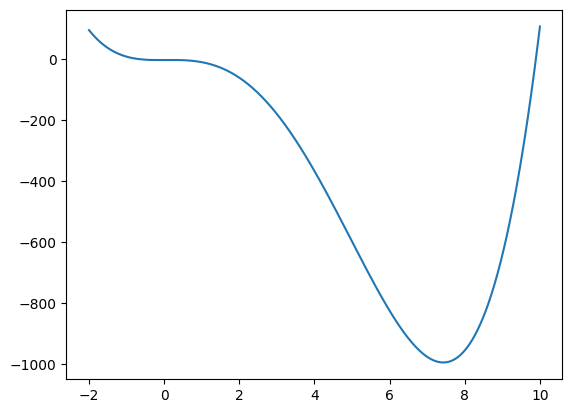

In [3]:
# The following lines will import the matplotlib library and enable plots to appear in the body of the notebook.
%matplotlib inline
from matplotlib import pyplot

x = numpy.linspace(-2,10,1000)
pyplot.plot(x,f(x))

Let's find the minimum, using 0 as a starting point:

In [4]:
print(fmin_bfgs(f, x0=0, fprime=fprime))

Optimization terminated successfully.
         Current function value: -4.093250
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
[-0.15101745]


Now let's omit the exact derivative of f and let `fmin_bfgs` use a numerical approximation of the derivative. The results should be close.

In [5]:
print(fmin_bfgs(f, x0=0))

Optimization terminated successfully.
         Current function value: -4.093250
         Iterations: 5
         Function evaluations: 16
         Gradient evaluations: 8
[-0.15101746]


We can suppress the messages using disp=False:

In [6]:
print(fmin_bfgs(f, x0=0, disp=False))

[-0.15101746]


### Exercise 1 _ Local minimum
Looks like we got stuck in a local miniumum. Print the values of `x` where `f(x)` has a minimum findable from the following starting points: -2, 0, 2, 6, 10

In [7]:
for x0 in [-2, 0, 2, 6, 10]:
    x_min = fmin_bfgs(f, x0=x0, disp=False)
    print("Starting at {} found minimum at {}".format(x0,x_min))

Starting at -2 found minimum at [-0.15101775]
Starting at 0 found minimum at [-0.15101746]
Starting at 2 found minimum at [7.42815758]
Starting at 6 found minimum at [7.42815774]
Starting at 10 found minimum at [7.4281578]



We can also use `fmin_bfgs` to minimize functions which take vectors rather than single numbers. For example, let's find the $x_1$ and $x_2$ which minimize the function $g(\mathbf{x}) = x_1^2 + x_2^2$ .

In [8]:
def g(x):
    return (x**2).sum()

x0 = numpy.array([-1, -1])
x1 = numpy.array([1,1])

print("Starting at {} found minimum at {}".format(x0, fmin_bfgs(g, x0=x0, disp=False)))
print("Starting at {} found minimum at {}".format(x1, fmin_bfgs(g, x0=x1, disp=False)))

Starting at [-1 -1] found minimum at [-7.13245457e-09 -7.13245452e-09]
Starting at [1 1] found minimum at [-1.07505143e-08 -1.07505143e-08]


### Exercise 2 _ Error function

In this exercise we will regress the fourth feature of the iris dataset agains the first three, using error function minimization. First prepare the data. We will use the function `train_test_split` from `sklearn` (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the data into training and validation portions. The named argument `random_state=` sets the random seed and makes sure we will get the same split every time.

In [9]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

X_train, X_val, y_train, y_val = train_test_split(iris.data[:,:3], 
                                                  iris.data[:,3], 
                                                  test_size=1/3, 
                                                  random_state=666)

Now define the error function on training data:

In [10]:
# wb is a list, where the first element is the bias term, and the rest are weights

def error(wb):
    '''Returns the error as a function of intercept and coefficients'''
    
    # We'll get the intercept as the fist element of wb, and the coefficients as the rest
    b = wb[0]
    w = wb[1:]
    
    # complete the function by returning the sum squared error 
    return numpy.sum((X_train.dot(w)+b - y_train)**2)

Let's define a starting point for the intercept and coefficients

In [11]:
# First item is the intercept b, the rest the coefficients w
wb0 = numpy.array([0.0, 0.0, 0.0, 0.0])

Now we are ready to find the values which minimize the error.

In [12]:
wb_min = fmin_bfgs(error, x0=wb0)
print(wb_min)

Optimization terminated successfully.
         Current function value: 2.869665
         Iterations: 5
         Function evaluations: 45
         Gradient evaluations: 9
[-0.26721216 -0.2234636   0.24483245  0.53565652]


The model that we have calculated above cannot be visualised as it contains >3 dimensions. 

### Exercise 3 _ MAE and r-squared

Let's check how well these parameters do on validation data, in terms of mean absolute error and r-squared. 

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error

b = wb_min[0]
w = wb_min[1:]

# calculating y_pred 
y_pred_val = X_val.dot(w) + b 
# calculating the r2 and MAE
r2 = r2_score( y_val, y_pred_val )
MAE = mean_absolute_error( y_val, y_pred_val )

print( 'r2 = {}'.format( r2 ))
print( 'MAE = {}'.format( MAE ))

r2 = 0.9151577699622208
MAE = 0.16703525204854405


### Exercise 4 _ Linear regression
Let us compare these results with the classic implementation of linear regression

In [14]:
from sklearn.linear_model import LinearRegression

# fitting the model
model = LinearRegression()
model = model.fit( X_train, y_train )

# looking at the coefficients of the model
print( 'weights: {}'.format( model.coef_ ) )
print( 'bias: {}'.format( model.intercept_ ) )
print()

# calculating y_pred on the validation set
y_pred_val = model.predict( X_val )

# evaluating the model using r2 and MAE
r2 = r2_score( y_val, y_pred_val )
MAE = mean_absolute_error( y_val, y_pred_val )

print( 'r2 = {}'.format( r2 ))
print( 'MAE = {}'.format( MAE ))

weights: [-0.22346222  0.24483198  0.53565595]
bias: -0.2672166046038522

r2 = 0.915157785470172
MAE = 0.16703526524839774


## Stochastic Gradient Descent

Scikit learn provides two classes `SGDRegressor` and `SGDClassifier` which use stochastic gradient descent to carry out linear regression and classification respectively.

These models are especially useful in these situations:
- with very large datasets
- with streaming data (they support online learning)
- with datasets with sparse features

SGD is sensitive to learning rate and the scale of the features. It's strongly recommended to z-score the features, and to tune the learning rate.
Z-scoring refers to subtracting the mean and dividing by standard deviation from each feature. The `sklearn` class `StandardScaler` can be used for this purpose.

In [15]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

We'll use the dataset of 50,000 songs. The prediction task is to guess the year the song was made based on 90 timbre features extracted from the audio. The year is in the first column.

In [16]:
songs = numpy.load("songs50k.npy")

X_train, X_val, y_train, y_val = train_test_split(songs[:,1:], songs[:,0], test_size=1/3, random_state=666)

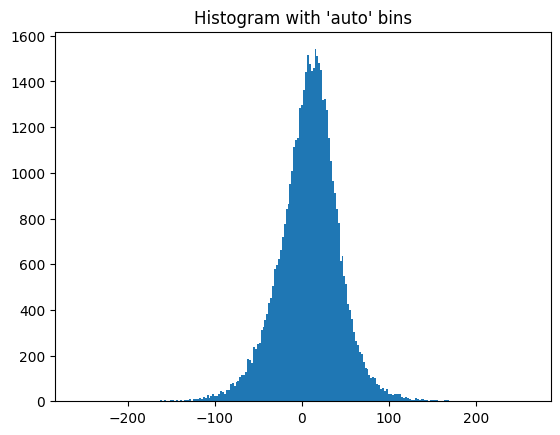

In [17]:
import numpy as np
import matplotlib.pyplot as plt

_ = plt.hist(songs[:,3], bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

### Exercise 5 _ SGD regressor

Train and evaluate the SGD regressor (we are calculating the MAE on the validation data, which gives us a hint that this is a regression problem) on the songs dataset. Take the following steps:
- z-score the training and validation features
- find good settings for learning rate type and learning rate initial value.
  - r-squared on validation data 
  - mean absolute error on validation data  

In [18]:
import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z  = scaler.transform(X_val)

lr = [ 10 ** x for x in range(-6,1)]

settings = []
for learning_rate in ['constant', 'optimal', 'invscaling']:
    for eta0 in lr:
        model = SGDRegressor(learning_rate=learning_rate, eta0=eta0, random_state=666)
        model.fit(X_train_z, y_train)
        mae = mean_absolute_error(y_val, model.predict(X_val_z))
        r2 =  r2_score(y_val, model.predict(X_val_z))
        settings.append((learning_rate, eta0, mae, r2))
best_mae = min(settings, key=lambda x: x[-2])
best_r2 =  max(settings, key=lambda x: x[-1])
print("Best settings according to MAE {}".format(best_mae))
print("Best settings according to R2 {}".format(best_r2))

Best settings according to MAE ('invscaling', 0.001, 6.7128155814399975, 0.2095458447287688)
Best settings according to R2 ('constant', 1e-05, 6.713323882187955, 0.21012983085739423)


### Exercise 6 _ Loss function

By default SGDRegressor tries to minimize the standard linear regression error function, that is sum of squared error. However this can be changed, via the `loss=` parameter. When `loss='squared_loss'`, sum of squared errors will be used. Other error functions available include [Huber loss](https://en.wikipedia.org/wiki/Huber_loss) (`loss='huber'`). Compared to squared loss, huber focuses less on outliers.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Huber_loss.svg/600px-Huber_loss.svg.png)

Repeat the steps from the previous exercise, but include the tuning of the loss function.

In [19]:
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z  =scaler.transform(X_val)

lr = [ 10 ** x for x in range(-6,1)]

settings = []

for learning_rate in ['constant', 'optimal', 'invscaling']:
    for loss in ['squared_error', 'huber']:
        for eta0 in lr:
            model = SGDRegressor(learning_rate=learning_rate, eta0=eta0, loss=loss,random_state=666)
            model.fit(X_train_z, y_train)
            mae = mean_absolute_error(y_val, model.predict(X_val_z))
            r2 =  r2_score(y_val, model.predict(X_val_z))
            settings.append((learning_rate, eta0, loss, mae, r2))
best_mae = min(settings, key=lambda x: x[-2])
best_r2 =  max(settings, key=lambda x: x[-1])
print("Best settings according to MAE {}".format(best_mae))
print("Best settings according to R2 {}".format(best_r2))

Best settings according to MAE ('invscaling', 0.1, 'huber', 6.4093292709541565, 0.1562073002691624)
Best settings according to R2 ('constant', 1e-05, 'squared_error', 6.713323882187955, 0.21012983085739423)
